# Learning a quadratic prior

This code attempts to learn a concave quadratic prior $J(x) = -\frac{1}{4}||x||_2^2$ in the context of a Hamilton-Jacobi PDE with a quadratic Hamiltonian $H(p) = \frac{1}{2}||p||_2^2$.
The LPN learns the function $\psi(x) = ||x||_2^2$.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/concave_quadratic_prior_16D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

## Parameters

In [2]:
# Parameters
# --- Parameters fof Experiment ---
dim_exp = 16  # Dimension (e.g., 2D, 4D, 8D as in the paper)
data_points_exp = 30000 # Example number of data points
iterations_exp_initial = 1 # Iterations for initial training phase
iterations_exp_long = 100000 # Iterations for longer training phase
a_exp = 4 # Grid limit for sampling y_j if using uniform, e.g., y_j in [-a, a]^d
spacing = 50 # For plotting cross-sections


# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers
eps = 0.5
# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

# === Section ===

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch 

# === Section 4.1.2: L1 Prior Helper Functions ===

def inner_prod(x, y):
    return np.sum(x * y, axis=1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def cvx_true_concave_quad(y_points): # y_points is N x dim
    """
    Computes the target function psi(y) = ||y||_2^2 for the given problem.
    """
    return euclid_norm_sq(y_points)

def prior_true_concave_quad(x_points):
    """
    Computes the true concave prior J(x) = -1/4 * ||x||_2^2.
    """
    return -0.25 * euclid_norm_sq(x_points)

def invert_prior_lpn(x, model, INVERT_MODE):
    y = invert(x,model,INVERT_MODE)
    return y

def evaluate_learned_prior_lpn(x_eval_points, y_inverted_points, model):
    try:
        y_tensor = torch.from_numpy(y_inverted_points).float().to(device)
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().cpu().numpy()
    except NameError: 
        print("Warning: 'device' not defined. Assuming CPU for evaluate_learned_prior.")
        y_tensor = torch.from_numpy(y_inverted_points).float()
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().numpy()
    prior_est = inner_prod(x_eval_points, y_inverted_points) - 0.5 * euclid_norm_sq(x_eval_points) - psi_of_y_inverted
    return prior_est


def compute_square_cross_sections(a, spacing, dim):
    xi = np.linspace(-a, a, spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid)
    x1_0_points[:, 0] = xi
    x2_0_points = np.copy(grid)
    if dim > 1:
        x2_0_points[:, 1] = xi
    elif dim == 1:
        x2_0_points = x1_0_points.copy()
    return xi, x1_0_points, x2_0_points

def cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim):
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    x1_0_psi_true = cvx_true_concave_quad(x1_0_points)
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_psi_true = cvx_true_concave_quad(x2_0_points)
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else: 
        x2_0_psi_true = x1_0_psi_true 
        x2_0_J_true = x1_0_J_true
        
    x1_0_psi_est = cvx(x1_0_points, model) 
    y1_inverted = invert_prior_lpn(x1_0_points, model, INVERT_MODE)
    x1_0_J_est = evaluate_learned_prior_lpn(x1_0_points,y1_inverted, model)
    if dim > 1:
        x2_0_psi_est = cvx(x2_0_points, model)
        y2_inverted = invert_prior_lpn(x2_0_points, model, INVERT_MODE)
        x2_0_J_est = evaluate_learned_prior_lpn(x2_0_points,y2_inverted, model)
    else:
        x2_0_psi_est = x1_0_psi_est
        x2_0_J_est = x1_0_J_est
        
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
    plt.plot(xi, x1_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=\\|x\\|_1$")
    plt.grid(True)
    plt.title(f"$\\psi(y_1,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
    plt.xlabel('$y_1$')
    plt.ylabel('$\\psi(y_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2) # Second plot for psi if dim > 1
        plt.plot(xi, x2_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
        plt.plot(xi, x2_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"$\\psi(0,y_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
        plt.xlabel('$y_2$')
        plt.ylabel('$\\psi(0,y_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_est, "-", label="LPN (Learned $J$)")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_est, "-", label="LPN (Learned $J$)")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

def plot_all_concave_quad(model, a, spacing, INVERT_MODE, dim):
    print(f"\n--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim={dim}) ---")
    cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim)



In [4]:
def evaluate_learned_H(model, a, spacing, dim):
    """
    Calculates and plots the approximate Hamiltonian H_theta.
    H_theta(p) = max_k { <p, eta_k> - b_k }
    where eta_k = x_k - grad_psi(x_k) and b_k = 0.5 * ||eta_k||^2
    """
    x_k_np = np.random.uniform(-a, a, (data_points_exp, dim))
    x_k_tensor = torch.from_numpy(x_k_np).float().to(device)
    x_k_tensor.requires_grad_(True)
    grad_psi_k_tensor = model(x_k_tensor)

    eta_k_tensor = x_k_tensor - grad_psi_k_tensor
    b_k_tensor = 0.5 * torch.sum(eta_k_tensor**2, dim=1, keepdim=True)

    xi = np.linspace(-a, a, spacing)
    p_eval_points_np = np.zeros((xi.size, dim))
    p_eval_points_np[:, 0] = xi
    p_eval_tensor = torch.from_numpy(p_eval_points_np).float().to(device)

    # Compute H_theta(p) for the cross-section
    inner_prods = torch.matmul(p_eval_tensor, eta_k_tensor.T)  # (spacing x data_points)
    H_theta_p_tensor = torch.max(inner_prods - b_k_tensor.T, dim=1, keepdim=True)[0]
    H_theta_p_np = H_theta_p_tensor.detach().cpu().numpy().flatten()

    # Compute true Hamiltonian H(p) = 0.5 * ||p||^2
    H_true_p_np = 0.5 * euclid_norm_sq(p_eval_points_np)

    plt.figure(figsize=(6,5))
    plt.plot(xi, H_theta_p_np, "-", label="Learned Hamiltonian $H_{\\theta}(p_1,0,...)$")
    plt.plot(xi, H_true_p_np, "--", label="True Hamiltonian $H(p)=1/2||p||_2^2$")
    plt.grid(True)
    plt.title(f"Hamiltonian Comparison - Dim {dim}")
    plt.xlabel('$p_1$')
    plt.ylabel('H(p)')
    plt.legend()
    plt.tight_layout()
    plt.show()


# --- Generate Training Data

In [5]:
# --- Generate Training Data for the new experiment ---
print("--- Generating Training Data for Concave Quadratic Prior ---")
y_j_exp_np = np.random.uniform(-a_exp, a_exp, (data_points_exp, dim_exp))
psi_samples_exp_np = cvx_true_concave_quad(y_j_exp_np)
psi_samples_exp_np = psi_samples_exp_np.reshape(-1, 1)

y_j_exp_tensor = torch.from_numpy(y_j_exp_np).float().to(device)
psi_samples_exp_tensor = torch.from_numpy(psi_samples_exp_np).float().to(device)
print(f"Generated training data: y_j_exp_tensor shape {y_j_exp_tensor.shape}, psi_samples_exp_tensor shape {psi_samples_exp_tensor.shape}")

# --- ADD THIS TO MOVE DATA TO GPU ---
y_j_exp_tensor = y_j_exp_tensor.to(device)
psi_samples_exp_tensor = psi_samples_exp_tensor.to(device)

--- Generating Training Data for Concave Quadratic Prior ---


Generated training data: y_j_exp_tensor shape torch.Size([30000, 16]), psi_samples_exp_tensor shape torch.Size([30000, 1])


## Training function

In [6]:
def single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    #elif loss_type == 0:
    #    loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [7]:

# --- Train and Plot with L2 Loss for the new experiment ---
print("\n--- Training LPN for Concave Quadratic Prior (Quadratic H) ---")
lpn_model_concave_quad_l2 = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta,eps=1e-3).to(device)
optimizer_concave_quad = torch.optim.Adam(lpn_model_concave_quad_l2.parameters(), lr=1e-4)

# Initial shorter training phase with a higher learning rate
for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

# Longer training phase with a reduced learning rate
for g in optimizer_concave_quad.param_groups:
    g["lr"] = 1e-4
for i in range(iterations_exp_long):
    if (i % 20000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer_concave_quad.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_concave_quad_l2.state_dict(), os.path.join(MODEL_DIR, "ConcaveQuadraticH_l2.pth"))



--- Training LPN for Concave Quadratic Prior (Quadratic H) ---


iteration 0 loss 7622.50439453125
iteration 0 loss 5691.2568359375


iteration 500 loss 128.25381469726562


iteration 1000 loss 110.51945495605469


iteration 1500 loss 101.75440216064453


iteration 2000 loss 97.14545440673828


iteration 2500 loss 93.30601501464844


iteration 3000 loss 88.90476989746094


iteration 3500 loss 83.49467468261719


iteration 4000 loss 76.72371673583984


iteration 4500 loss 68.04332733154297


iteration 5000 loss 56.35095977783203


iteration 5500 loss 39.27403259277344


iteration 6000 loss 19.434616088867188


iteration 6500 loss 11.457850456237793


iteration 7000 loss 8.210272789001465


iteration 7500 loss 6.424639701843262


iteration 8000 loss 5.277810573577881


iteration 8500 loss 4.472089767456055


iteration 9000 loss 3.8524489402770996


iteration 9500 loss 3.3657619953155518


iteration 10000 loss 2.96882700920105


iteration 10500 loss 2.632073163986206


iteration 11000 loss 2.366457939147949


iteration 11500 loss 2.1472198963165283


iteration 12000 loss 1.9752697944641113


iteration 12500 loss 1.8504232168197632


iteration 13000 loss 1.7347286939620972


iteration 13500 loss 1.6416749954223633


iteration 14000 loss 1.5475914478302002


iteration 14500 loss 1.475943684577942


iteration 15000 loss 1.40397310256958


iteration 15500 loss 1.3346359729766846


iteration 16000 loss 1.277665138244629


iteration 16500 loss 1.2117334604263306


iteration 17000 loss 1.1673721075057983


iteration 17500 loss 1.1150609254837036


iteration 18000 loss 1.0635955333709717


iteration 18500 loss 1.0183911323547363


iteration 19000 loss 0.9679204821586609


iteration 19500 loss 0.929033100605011


Learning rate decreased to 1e-05 at iteration 20000
iteration 20000 loss 0.8828652501106262


iteration 20500 loss 0.8773437142372131


iteration 21000 loss 0.8703699707984924


iteration 21500 loss 0.8615888953208923


iteration 22000 loss 0.8506255745887756


iteration 22500 loss 0.8370954394340515


iteration 23000 loss 0.82065349817276


iteration 23500 loss 0.8010203242301941


iteration 24000 loss 0.7780390977859497


iteration 24500 loss 0.7517486810684204


iteration 25000 loss 0.7232183218002319


iteration 25500 loss 0.6952793002128601


iteration 26000 loss 0.6684983372688293


iteration 26500 loss 0.6424907445907593


iteration 27000 loss 0.6178174614906311


iteration 27500 loss 0.5939396023750305


iteration 28000 loss 0.5709261894226074


iteration 28500 loss 0.5487263202667236


iteration 29000 loss 0.5277538895606995


iteration 29500 loss 0.507451057434082


iteration 30000 loss 0.48798030614852905


iteration 30500 loss 0.4695391058921814


iteration 31000 loss 0.45205774903297424


iteration 31500 loss 0.43520626425743103


iteration 32000 loss 0.41936686635017395


iteration 32500 loss 0.40399643778800964


iteration 33000 loss 0.389467716217041


iteration 33500 loss 0.37574484944343567


iteration 34000 loss 0.3627391457557678


iteration 34500 loss 0.35041186213493347


iteration 35000 loss 0.3389393389225006


iteration 35500 loss 0.3279092609882355


iteration 36000 loss 0.31738731265068054


iteration 36500 loss 0.3075002133846283


iteration 37000 loss 0.29826000332832336


iteration 37500 loss 0.2893974781036377


iteration 38000 loss 0.2810443341732025


iteration 38500 loss 0.2730708718299866


iteration 39000 loss 0.26565632224082947


iteration 39500 loss 0.25860580801963806


Learning rate decreased to 1.0000000000000002e-06 at iteration 40000
iteration 40000 loss 0.25190356373786926


iteration 40500 loss 0.2511972188949585


iteration 41000 loss 0.2503342926502228


iteration 41500 loss 0.24929387867450714


iteration 42000 loss 0.24806296825408936


iteration 42500 loss 0.24663786590099335


iteration 43000 loss 0.2450246810913086


iteration 43500 loss 0.24324236810207367


iteration 44000 loss 0.24131768941879272


iteration 44500 loss 0.2392822951078415


iteration 45000 loss 0.23717698454856873


iteration 45500 loss 0.23505468666553497


iteration 46000 loss 0.2329360395669937


iteration 46500 loss 0.23084717988967896


iteration 47000 loss 0.2287990152835846


iteration 47500 loss 0.2267906218767166


iteration 48000 loss 0.2248149812221527


iteration 48500 loss 0.22287188470363617


iteration 49000 loss 0.22095753252506256


iteration 49500 loss 0.21907205879688263


iteration 50000 loss 0.21721379458904266


iteration 50500 loss 0.2153799831867218


iteration 51000 loss 0.21356934309005737


iteration 51500 loss 0.21178151667118073


iteration 52000 loss 0.2100154012441635


iteration 52500 loss 0.20827341079711914


iteration 53000 loss 0.20655088126659393


iteration 53500 loss 0.204848051071167


iteration 54000 loss 0.20316682755947113


iteration 54500 loss 0.2015029788017273


iteration 55000 loss 0.1998581886291504


iteration 55500 loss 0.1982324868440628


iteration 56000 loss 0.19662396609783173


iteration 56500 loss 0.19503769278526306


iteration 57000 loss 0.19346512854099274


iteration 57500 loss 0.19191090762615204


iteration 58000 loss 0.1903730183839798


iteration 58500 loss 0.1888517290353775


iteration 59000 loss 0.18734616041183472


iteration 59500 loss 0.18585804104804993


Learning rate decreased to 1.0000000000000002e-07 at iteration 60000
iteration 60000 loss 0.18438509106636047


iteration 60500 loss 0.18423402309417725


iteration 61000 loss 0.1840750128030777


iteration 61500 loss 0.18390914797782898


iteration 62000 loss 0.1837378889322281


iteration 62500 loss 0.18356266617774963


iteration 63000 loss 0.1833844780921936


iteration 63500 loss 0.18320444226264954


iteration 64000 loss 0.18302352726459503


iteration 64500 loss 0.18284247815608978


iteration 65000 loss 0.18266156315803528


iteration 65500 loss 0.18248121440410614


iteration 66000 loss 0.18230201303958893


iteration 66500 loss 0.18212354183197021


iteration 67000 loss 0.18194593489170074


iteration 67500 loss 0.1817689836025238


iteration 68000 loss 0.181592658162117


iteration 68500 loss 0.18141698837280273


iteration 69000 loss 0.18124188482761383


iteration 69500 loss 0.1810673177242279


iteration 70000 loss 0.1808931976556778


iteration 70500 loss 0.18071945011615753


iteration 71000 loss 0.18054619431495667


iteration 71500 loss 0.18037328124046326


iteration 72000 loss 0.18020078539848328


iteration 72500 loss 0.18002866208553314


iteration 73000 loss 0.1798568069934845


iteration 73500 loss 0.17968539893627167


iteration 74000 loss 0.17951419949531555


iteration 74500 loss 0.17934338748455048


iteration 75000 loss 0.17917288839817047


iteration 75500 loss 0.17900267243385315


iteration 76000 loss 0.17883281409740448


iteration 76500 loss 0.1786632239818573


iteration 77000 loss 0.17849384248256683


iteration 77500 loss 0.1783248484134674


iteration 78000 loss 0.17815598845481873


iteration 78500 loss 0.1779874861240387


iteration 79000 loss 0.17781920731067657


iteration 79500 loss 0.17765121161937714


Learning rate decreased to 1.0000000000000004e-08 at iteration 80000
iteration 80000 loss 0.177483469247818


iteration 80500 loss 0.17746850848197937


iteration 81000 loss 0.17745345830917358


iteration 81500 loss 0.17743848264217377


iteration 82000 loss 0.1774234026670456


iteration 82500 loss 0.17740841209888458


iteration 83000 loss 0.17739327251911163


iteration 83500 loss 0.17737825214862823


iteration 84000 loss 0.17736326158046722


iteration 84500 loss 0.17734818160533905


iteration 85000 loss 0.17733317613601685


iteration 85500 loss 0.17731820046901703


iteration 86000 loss 0.17730316519737244


iteration 86500 loss 0.177288219332695


iteration 87000 loss 0.17727318406105042


iteration 87500 loss 0.17725823819637299


iteration 88000 loss 0.17724329233169556


iteration 88500 loss 0.17722836136817932


iteration 89000 loss 0.17721344530582428


iteration 89500 loss 0.17719848453998566


iteration 90000 loss 0.1771835833787918


iteration 90500 loss 0.17716865241527557


iteration 91000 loss 0.17715369164943695


iteration 91500 loss 0.17713883519172668


iteration 92000 loss 0.17712396383285522


iteration 92500 loss 0.17710907757282257


iteration 93000 loss 0.1770942062139511


iteration 93500 loss 0.17707927525043488


iteration 94000 loss 0.17706438899040222


iteration 94500 loss 0.17704954743385315


iteration 95000 loss 0.17703473567962646


iteration 95500 loss 0.17701980471611023


iteration 96000 loss 0.17700494825839996


iteration 96500 loss 0.1769901067018509


iteration 97000 loss 0.17697526514530182


iteration 97500 loss 0.17696033418178558


iteration 98000 loss 0.17694558203220367


iteration 98500 loss 0.17693071067333221


iteration 99000 loss 0.17691586911678314


iteration 99500 loss 0.17690101265907288


L2 loss -- Plot


--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim=16) ---
loss 2.698835849761963


loss -48.13756561279297


loss -71.10679626464844


loss -82.13018798828125


loss -86.63133239746094


loss -88.20008087158203


loss -88.65752410888672


loss -88.76380920410156


loss -88.78215789794922


loss -88.78429412841797


loss -88.7844467163086


loss -88.78445434570312


loss -88.78445434570312


loss -88.78445434570312


loss -88.78445434570312


loss -88.78445434570312


loss -88.78445434570312


loss -88.78445434570312


loss -88.78445434570312


loss -88.78445434570312


loss -88.78445434570312


loss -88.78445434570312


loss -88.78445434570312


loss -88.78445434570312


loss -88.78445434570312


loss -88.78445434570312


loss -88.78446197509766


loss -88.78445434570312


loss -88.78445434570312


loss -88.78445434570312


loss -88.78445434570312


loss -88.78445434570312


loss -88.78445434570312


loss -88.78445434570312


loss -88.78445434570312


loss -88.78445434570312


loss -88.78445434570312


loss -88.78445434570312


loss -88.7844467163086


loss -88.78445434570312


final mse:  6.90053347796038e-09
max, min: 2.1484842 -1.9784223
loss 2.698835849761963


loss -43.76449203491211


loss -62.77051544189453


loss -71.67626953125


loss -75.49305725097656


loss -77.02779388427734


loss -77.58047485351562


loss -77.74592590332031


loss -77.7839126586914


loss -77.78998565673828


loss -77.79059600830078


loss -77.79063415527344


loss -77.79061889648438


loss -77.79063415527344


loss -77.79063415527344


loss -77.79063415527344


loss -77.79063415527344


loss -77.79063415527344


loss -77.79063415527344


loss -77.7906265258789


loss -77.79063415527344


loss -77.79063415527344


loss -77.7906265258789


loss -77.79063415527344


loss -77.79063415527344


loss -77.79063415527344


loss -77.79063415527344


loss -77.79063415527344


loss -77.7906265258789


loss -77.79063415527344


loss -77.7906265258789


loss -77.79063415527344


loss -77.7906265258789


loss -77.79063415527344


loss -77.79063415527344


loss -77.79063415527344


loss -77.7906265258789


loss -77.79063415527344


loss -77.79063415527344


loss -77.79063415527344


final mse:  6.6721956848425634e-09
max, min: 2.1968863 -2.0978897


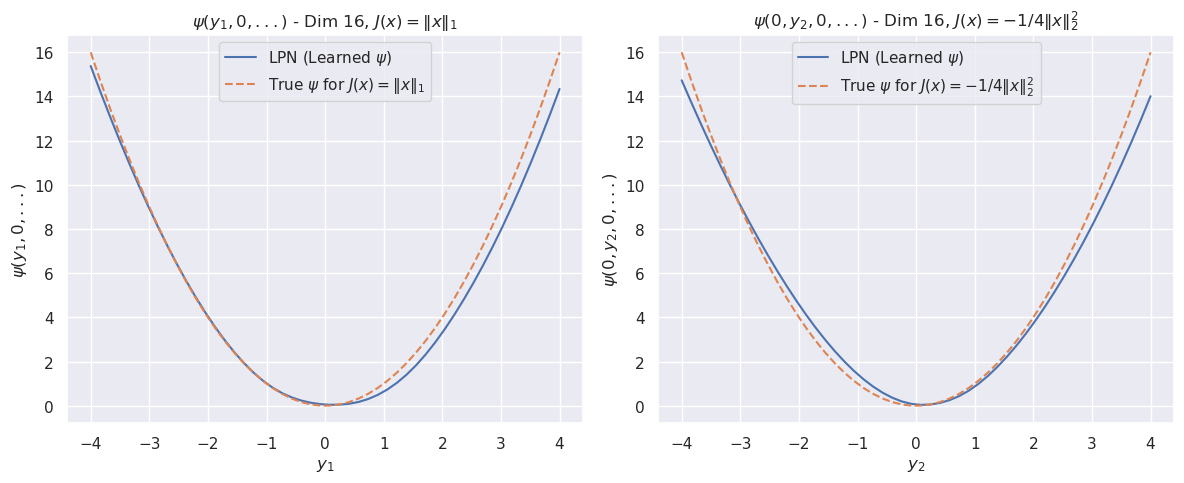

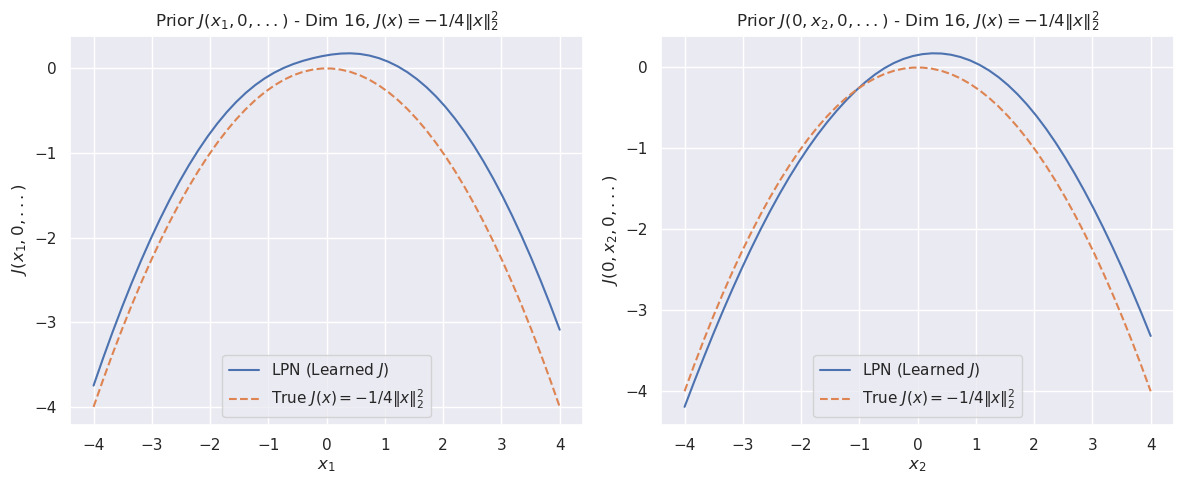

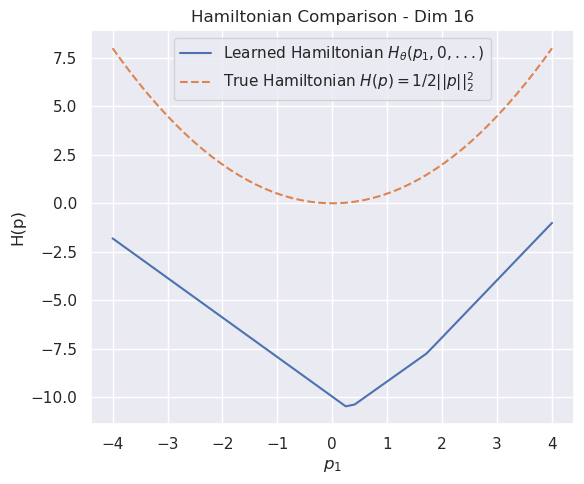

In [8]:
#print("\n--- Plotting Cross Sections for Quadratic H, Concave Quad Prior (Dim=4) ---")
plot_all_concave_quad(lpn_model_concave_quad_l2, a_exp, spacing, INVERT_MODE, dim_exp)

#print("\n--- Plotting Learned Hamiltonian for Quadratic H, Concave Quad Prior ---")
#evaluate_learned_H(lpn_model_concave_quad_l2, a_exp, spacing, dim_exp)

In [9]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = y_j_exp_tensor.clone().to(device)
x_k_tensor.requires_grad_(True)

# 1. Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model_concave_quad_l2.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model_concave_quad_l2(x_k_tensor)

# 2. Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

# Detach the tensor to treat G_k as fixed targets, breaking the connection
# to the first LPN's graph and preventing the RuntimeError during training.
G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

# The input tensor x_k_tensor is still needed for the second LPN training,
# but it should also not require a gradient for that training.
x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)
# G_samples_tensor now holds the target values G_k
print(f"Generated G samples: G_samples_tensor shape {G_samples_tensor.shape}")




Generated G samples: G_samples_tensor shape torch.Size([30000, 1])


In [10]:
# --- Step 3: Train LPN G(x) ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
# The target for this LPN is G_samples_tensor
# The input for this LPN is x_k_tensor
lpn_model_G = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-4)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-4 # Use a smaller learning rate for the long phase
for i in range(iterations_exp_long):
    if (i % 20000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of LPN for G(x) complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 7662.97607421875
iteration 0 loss 4740.3603515625


iteration 500 loss 130.3306121826172


iteration 1000 loss 111.88943481445312


iteration 1500 loss 103.6375503540039


iteration 2000 loss 99.43069458007812


iteration 2500 loss 95.89656829833984


iteration 3000 loss 91.8843994140625


iteration 3500 loss 87.06822967529297


iteration 4000 loss 81.21597290039062


iteration 4500 loss 73.99752044677734


iteration 5000 loss 64.50707244873047


iteration 5500 loss 49.90771484375


iteration 6000 loss 24.721834182739258


iteration 6500 loss 10.550329208374023


iteration 7000 loss 7.082952499389648


iteration 7500 loss 5.407773017883301


iteration 8000 loss 4.373764991760254


iteration 8500 loss 3.702692747116089


iteration 9000 loss 3.2299063205718994


iteration 9500 loss 2.88698148727417


iteration 10000 loss 2.626059055328369


iteration 10500 loss 2.4426026344299316


iteration 11000 loss 2.2900497913360596


iteration 11500 loss 2.156353235244751


iteration 12000 loss 2.0770530700683594


iteration 12500 loss 1.9934123754501343


iteration 13000 loss 1.9062812328338623


iteration 13500 loss 1.842423677444458


iteration 14000 loss 1.783734917640686


iteration 14500 loss 1.7222052812576294


iteration 15000 loss 1.6846837997436523


iteration 15500 loss 1.642866849899292


iteration 16000 loss 1.6033568382263184


iteration 16500 loss 1.5741833448410034


iteration 17000 loss 1.5383391380310059


iteration 17500 loss 1.5054455995559692


iteration 18000 loss 1.4844005107879639


iteration 18500 loss 1.4594945907592773


iteration 19000 loss 1.4311692714691162


iteration 19500 loss 1.411901593208313


Learning rate decreased to 1e-05 at iteration 20000
iteration 20000 loss 1.3958876132965088


iteration 20500 loss 1.3938859701156616


iteration 21000 loss 1.391339898109436


iteration 21500 loss 1.3881072998046875


iteration 22000 loss 1.3840237855911255


iteration 22500 loss 1.3788849115371704


iteration 23000 loss 1.3724615573883057


iteration 23500 loss 1.364498496055603


iteration 24000 loss 1.354730248451233


iteration 24500 loss 1.3428266048431396


iteration 25000 loss 1.3283956050872803


iteration 25500 loss 1.3116518259048462


iteration 26000 loss 1.2932323217391968


iteration 26500 loss 1.2746624946594238


iteration 27000 loss 1.2567471265792847


iteration 27500 loss 1.2391130924224854


iteration 28000 loss 1.222261905670166


iteration 28500 loss 1.2060606479644775


iteration 29000 loss 1.1903982162475586


iteration 29500 loss 1.1751502752304077


iteration 30000 loss 1.1604721546173096


iteration 30500 loss 1.1459578275680542


iteration 31000 loss 1.131869912147522


iteration 31500 loss 1.1183067560195923


iteration 32000 loss 1.1051706075668335


iteration 32500 loss 1.0921133756637573


iteration 33000 loss 1.0792255401611328


iteration 33500 loss 1.0664565563201904


iteration 34000 loss 1.0540820360183716


iteration 34500 loss 1.0419769287109375


iteration 35000 loss 1.0301697254180908


iteration 35500 loss 1.0185682773590088


iteration 36000 loss 1.0072442293167114


iteration 36500 loss 0.9959967136383057


iteration 37000 loss 0.9848024249076843


iteration 37500 loss 0.9737048745155334


iteration 38000 loss 0.9629102945327759


iteration 38500 loss 0.952218234539032


iteration 39000 loss 0.9416102766990662


iteration 39500 loss 0.9312687516212463


Learning rate decreased to 1.0000000000000002e-06 at iteration 40000
iteration 40000 loss 0.9209954142570496


iteration 40500 loss 0.9198771715164185


iteration 41000 loss 0.9185652732849121


iteration 41500 loss 0.9170558452606201


iteration 42000 loss 0.91535484790802


iteration 42500 loss 0.9134781360626221


iteration 43000 loss 0.9114488363265991


iteration 43500 loss 0.9092967510223389


iteration 44000 loss 0.9070500731468201


iteration 44500 loss 0.9047392010688782


iteration 45000 loss 0.9023871421813965


iteration 45500 loss 0.9000228047370911


iteration 46000 loss 0.8976657390594482


iteration 46500 loss 0.8953346014022827


iteration 47000 loss 0.8930286169052124


iteration 47500 loss 0.8907405734062195


iteration 48000 loss 0.8884678483009338


iteration 48500 loss 0.8862094879150391


iteration 49000 loss 0.8839649558067322


iteration 49500 loss 0.8817285299301147


iteration 50000 loss 0.8795031309127808


iteration 50500 loss 0.8772866129875183


iteration 51000 loss 0.8750766515731812


iteration 51500 loss 0.8728717565536499


iteration 52000 loss 0.8706731200218201


iteration 52500 loss 0.8684802055358887


iteration 53000 loss 0.8662936091423035


iteration 53500 loss 0.8641151189804077


iteration 54000 loss 0.8619398474693298


iteration 54500 loss 0.8597711324691772


iteration 55000 loss 0.8576078414916992


iteration 55500 loss 0.8554484248161316


iteration 56000 loss 0.8532938957214355


iteration 56500 loss 0.8511437177658081


iteration 57000 loss 0.8489959836006165


iteration 57500 loss 0.8468532562255859


iteration 58000 loss 0.8447151184082031


iteration 58500 loss 0.8425811529159546


iteration 59000 loss 0.8404513597488403


iteration 59500 loss 0.8383254408836365


Learning rate decreased to 1.0000000000000002e-07 at iteration 60000
iteration 60000 loss 0.8362066745758057


iteration 60500 loss 0.8359938263893127


iteration 61000 loss 0.8357771039009094


iteration 61500 loss 0.8355571627616882


iteration 62000 loss 0.8353348970413208


iteration 62500 loss 0.8351110816001892


iteration 63000 loss 0.8348864912986755


iteration 63500 loss 0.8346611857414246


iteration 64000 loss 0.8344363570213318


iteration 64500 loss 0.8342112898826599


iteration 65000 loss 0.8339865803718567


iteration 65500 loss 0.8337621688842773


iteration 66000 loss 0.8335384130477905


iteration 66500 loss 0.8333151340484619


iteration 67000 loss 0.833092212677002


iteration 67500 loss 0.8328696489334106


iteration 68000 loss 0.8326475620269775


iteration 68500 loss 0.8324255347251892


iteration 69000 loss 0.83220374584198


iteration 69500 loss 0.8319823145866394


iteration 70000 loss 0.8317611217498779


iteration 70500 loss 0.8315399885177612


iteration 71000 loss 0.8313191533088684


iteration 71500 loss 0.831098735332489


iteration 72000 loss 0.8308780193328857


iteration 72500 loss 0.8306578397750854


iteration 73000 loss 0.8304376602172852


iteration 73500 loss 0.8302178382873535


iteration 74000 loss 0.8299978971481323


iteration 74500 loss 0.8297783732414246


iteration 75000 loss 0.8295587301254272


iteration 75500 loss 0.8293394446372986


iteration 76000 loss 0.8291202783584595


iteration 76500 loss 0.8289011716842651


iteration 77000 loss 0.8286821246147156


iteration 77500 loss 0.8284631967544556


iteration 78000 loss 0.8282442688941956


iteration 78500 loss 0.8280256390571594


iteration 79000 loss 0.8278071880340576


iteration 79500 loss 0.8275883197784424


Learning rate decreased to 1.0000000000000004e-08 at iteration 80000
iteration 80000 loss 0.8273700475692749


iteration 80500 loss 0.8273506760597229


iteration 81000 loss 0.8273312449455261


iteration 81500 loss 0.8273118734359741


iteration 82000 loss 0.8272925615310669


iteration 82500 loss 0.8272729516029358


iteration 83000 loss 0.8272535800933838


iteration 83500 loss 0.8272342085838318


iteration 84000 loss 0.8272147178649902


iteration 84500 loss 0.8271953463554382


iteration 85000 loss 0.827176034450531


iteration 85500 loss 0.827156662940979


iteration 86000 loss 0.8271372318267822


iteration 86500 loss 0.8271179795265198


iteration 87000 loss 0.827098548412323


iteration 87500 loss 0.827079176902771


iteration 88000 loss 0.8270599246025085


iteration 88500 loss 0.8270403742790222


iteration 89000 loss 0.8270212411880493


iteration 89500 loss 0.8270018100738525


iteration 90000 loss 0.8269825577735901


iteration 90500 loss 0.8269633054733276


iteration 91000 loss 0.8269439339637756


iteration 91500 loss 0.8269245624542236


iteration 92000 loss 0.826905369758606


iteration 92500 loss 0.8268859386444092


iteration 93000 loss 0.8268666863441467


iteration 93500 loss 0.8268474340438843


iteration 94000 loss 0.8268280625343323


iteration 94500 loss 0.8268088698387146


iteration 95000 loss 0.8267896175384521


iteration 95500 loss 0.8267702460289001


iteration 96000 loss 0.8267509937286377


iteration 96500 loss 0.82673180103302


iteration 97000 loss 0.8267126679420471


iteration 97500 loss 0.8266934752464294


iteration 98000 loss 0.8266739845275879


iteration 98500 loss 0.826654851436615


iteration 99000 loss 0.8266355395317078


iteration 99500 loss 0.8266162276268005


Training of LPN for G(x) complete and model saved.



--- Plotting Estimated Prior J(x) from LPN 2 ---


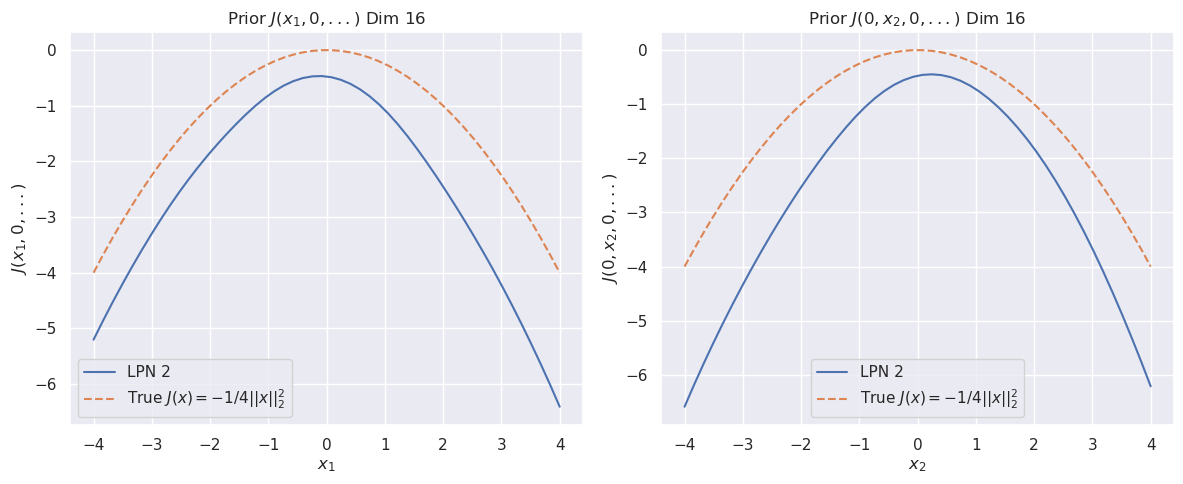

In [11]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    # Get G(x) from the second LPN model
    G_x = model_G.scalar(x_tensor)
    
    # Compute 0.5 * ||x||^2
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    # Apply the formula: J_est = G(x) - 0.5 * ||x||^2
    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    # True Prior
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    # Estimated Prior from G(x) Network
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from LPN 2 ---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    #plt.savefig('G_network_prior_plot.png')
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a_exp, spacing, dim_exp)